# Material Balances VII

This lecture solves more Material Balance Example Problems. Unlike prior Notebooks, we focus here on solving PFR and Batch reactor material balance problems using numerical ODE solvers. Prior to starting this Notebook, it will be helpful to review [Notebook 19](https://jqbond.github.io/CEN587/Notebooks/587-N19.html), which covers the basics of numerical ODE solvers as well as how they are implemented in Python. For additional information, ODE solvers are covered in more detail in [Supplement 14](https://jqbond.github.io/CEN587/Supplements/587-S14.html). A related tool for approximating the solution to definite integrals is Gaussian Quadrature, which is covered in [Supplement 15](https://jqbond.github.io/CEN587/Supplements/587-S15.html).

In [15]:
import numpy as np
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.optimize as opt

## Example Problem 01

Consider the following gas-phase, irreversible, homogeneous reaction that is occurring in an isothermal plug flow reactor. 

$$6A + 19B \rightarrow C$$

This reaction is first order in A and first order in B. Additional data are given below:

\begin{align*}
    k &= 25.3 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
    T &= 573 \ \textrm{K}\\
    P &= 1.0 \ \textrm{atm}\\
    F_{Af} &= 3.7 \ \textrm{mol} \ \textrm{h}^{-1}\\
    F_{Bf} &= 9.3 \ \textrm{mol} \ \textrm{h}^{-1}
\end{align*}

What PFR volume is required to achieve a fractional conversion of species B ($X_B$) of 85\%? 	

**Answer**: $V_\mathrm{PFR} = 179 L$


### Solution to Example Problem 01

After extensive examples from the previous few notebooks, we are probably thinking that we should write a material balance for this PFR and work through an analytical solution. This system only deals with a single reaction, so it is probably possible to do so. We will start by taking the same approaches that we used in [Notebook 16](https://jqbond.github.io/CEN587/Notebooks/587-N16.html), [Notebook 17](https://jqbond.github.io/CEN587/Notebooks/587-N17.html), and [Notebook 18](https://jqbond.github.io/CEN587/Notebooks/587-N18.html). Specifically, because this problem asks about the PFR size required to achieve a certain conversion of species B, we will begin by writing a balance on Species B in a PFR at Steady state:

$$\frac{dF_B}{dV} = R_B$$

We define $R_B$ using stoichiometric coefficients, $\nu{i,j}$ and reaction rates, $r_i$ as usual:

$$R_B = \sum_{i = 1}^{N_R} \nu_{i,B} \, r_i$$

We again have a single reaction, so:

$$R_B = -19r$$

The problem statement tells us that the reaction is first order in $A$ and first order in $B$, so:

$$r = kC_AC_B$$

Then:

$$R_B = -19kC_AC_B$$

We substitute this into the material balance to get:

$$\frac{dF_B}{dV} = -19kC_AC_B$$

As usual, we have several state dependent variables. We'll try to work through our typical tricks of expressing everything in terms of flowrates and fractional conversions. Because this is a flow reactor operating at steady state, we will define concentrations using molar flowrates and volumetric flowrates:

$$C_A = \frac{F_A}{Q}$$

and

$$C_B = \frac{F_B}{Q}$$

Where $F_j$ is the molar flowrate of j at position "V" in the reactor, and $Q$ is the volumetric flowrate at position "V" in the reactor. Species molar flowrates, $F_j$, are all generally functions of position in the reactor. Further, we definitely have a change in the number of moles as reactants (25 moles) form products (1 mole), so $Q$ is not constant and is also a function of position in the reactor. We must calculate $Q$ inside of the reactor using an equation of state. Since we're at 1 bar, we'll use the ideal gas law.

$$Q = \frac{F_{T}RT}{P}$$

Substituting relevant quantities back into our material balance, we get:

$$\frac{dF_B}{dV} = -19k\frac{F_AF_B}{F_T^2}\left(\frac{P}{RT}\right)^2$$

Unfortunately, this ODE is not yet separable because we have $F_A$, $F_B$, and $F_T$ all changing as a function of volume. We need to express all variable quantities on the right hand side of the ODE in terms of a single state variable. We can do so by writing a mole table for all species as functions of fractional conversion of B. This gives:

\begin{align*}
    F_A &= F_{A,f} - 6/19F_{B,f}X_B \\
    F_B &= F_{B,f} - F_{B,f}X_B \\
    F_C &= F_{C,f} + 1/19F_{B,f}X_B \\
    F_T &= F_{T,f} - 24/19F_{B,f}X_B \\
\end{align*}
    
Where $F_{T,f} = F_{A,f} + F_{B,f} + F_{C,f}$. We substitute these molar flowrates into our ODE. After factoring and simplifications similar to those demonstrated in [Example Problem 01 from Notebook 18](https://jqbond.github.io/CEN587/Notebooks/587-N18.html), we get the following:

$$\frac{dX_B}{dV} = k\frac{6 \times 19^2}{24^2F_{B,f}}\left(\frac{P}{RT}\right)^2\frac{(\theta_A - X_B)(1 - X_B)}{(\theta_T - X_B))^2}$$

Technically, this ***is*** a separable ODE.

$$\frac{(\theta_T - X_B)^2}{(\theta_A - X_B)(1 - X_B)}dX_B = k\frac{6 \times 19^2}{24^2F_{B,f}}\left(\frac{P}{RT}\right)^2 dV$$

But 😭

Honestly, I can't find a concise, closed form solution for this in my typical CRE integral tables. One can find a solution using a partial fraction decomposition, but this is the point where it starts to get pretty unwieldy. I've tried outsourcing the calculus to Chat-GPT and Wolfram, which both give me a solution, but I haven't successfully applied it to get the correct numerical answer yet because it is complex and difficult to make numerical substitutions correctly. Here, I really just want to solve for the volume required to achieve 85% conversion.  I can do this much more easily and concisely with Gaussian Quadrature. Specifically, if we restructure the above equation a little, we'll see that the volume is just given by a definite integral, which we can solve on a calculator or with quadrature in Python.

### Solving Example Problem 01 by Quadrature

$$\int_0^{V} dV = V = \frac{1}{k}\frac{24^2F_{B,f}}{6 \times 19^2}\left(\frac{RT}{P}\right)^2 \int_0^{0.85}\frac{(\theta_T - X_B)^2}{(\theta_A - X_B)(1 - X_B)}dX_B$$

Solving the integral on the right hand side, we find that:

$V = 179.7 L$

In [16]:
#############################################################################
# Solving Example Problem 01 using Gaussian Quadrature                      #
#############################################################################

k   = 25.3      #L/mol/h
FAf = 3.7       #mol/h
FBf = 9.3       #mol/h
FCf = 0         #mol/h
FTf = FAf + FBf + FCf

T   = 573      #K
P   = 1.0      #atm
R   = 0.08206  #L*atm/mol/K
θA  = 19/6*FAf/FBf
θT  = 19/24*FTf/FBf

###################################################
# Construct the integrand function                #
###################################################

INT = lambda X: (24**2*FBf/6/19**2/k*(R*T/P)**2*(θT - X)**2/(θA - X)/(1 - X))

###################################################
# Integrate using Gaussian Quadrature             #
###################################################

V, err   = quad(INT, 0, 0.85)
print(f'V = {V:6.2f}L')

V = 179.72L


#### An important takeaway

It is generally adviseable to obtain an analytical solution if it is possible to do so, but we also have to recognize that when problems get more complex, analytical solutions become messy (at best) or completely intractable (at worst). In most cases, we end up having to solve them using a computer with some type of numerical method -- this applies whether or not we've done extensive algebraic manipulations as in the above attempt at an analytical solution. If we're going to use a computer anyway (as above), my advice is to lean hard into using the computer. I prefer not to spend a lot of time and effort deriving a complicated equation like the final ODE above. I don't like doing this because it is tedious and, inevitably, I make mistakes and have trouble figuring out where I made them because the final equations are incomprehenisble in terms of the physical significance of the terms in them.

### Alternate Solution to Example Problem 01 using `solve_ivp()`

```{note}
Here's the approach I prefer. I learned this method from Jim Rawlings, and it is applied throughout *Chemical Reactor Analysis and Design Fundamentals, 2nd ed.* by Rawlings and Ekerdt. 
```

Above, we resolved having many state dependent variables and only 1 equation by reducing the number of dependent variables to one, namely the fractional conversion of species B, $X_B$. An alternate approach is to add more equations. Instead of expressing $F_A$, $F_B$, and $F_C$ in terms of fractional conversion of $B$, we just write material balances on $A$, $B$, and $C$ if we find we need to know how $A$, $B$, and $C$ change as a function of time, reactor volume, etc. So, for this problem, we would start out as usual by writing a balance on B (see first part of solution above):

$$\frac{dF_B}{dV} = -19kC_AC_B$$

But we see as usual that we also need to know FA to figure out CA since:

$$C_A = \frac{F_A}{Q}$$

Not only that, we know that $Q$ is determined by the total molar flowrate:

$$F_T = F_A + F_B + F_C$$

So we actually need to know $F_C$ as well.  My preference in this case is to just write balances on each species.

\begin{align*}
    \frac{dF_A}{dV} &= R_A \\
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_C}{dV} &= R_C \\
\end{align*}

Once we do this, we follow this guidance: we write everything on the right hand side of our differential equations in terms of the indpendent variable ($V$) and/or the state dependent variables ($F_A$, $F_B$, and $F_C$). With that in mind:

\begin{align*}
    R_A &= -6r \\
    R_B &= -19r \\
    R_C &= r \\
\end{align*}

We know the rate law, so:

$$r = kC_AC_B$$

We also know how to define concentrations in terms of flowrates:

\begin{align*}
    C_A = F_A/Q \\
    C_B = F_B/Q \\ 
    C_C = F_C/Q \\
\end{align*}

Further, we know that $Q$ can be obtained using the ideal gas law:

$$Q = \frac{F_T RT}{P}$$

That's all good because we can express the total molar flowrate in terms of individual species flowrates:

$$F_T = F_A + F_B + F_C$$

With that, the problem is effectively solved. If you carefully review the above set of equations, you'll find that the right hand side of each differential equation is fully defined as an explicit function of $F_A$, $F_B$, $F_C$, and/or $V$. We can now integrate this using `solve_ivp()` from `scipy.integrate`. First, we build the ODE system into a function. In doing so, we should remember the requirements for functions passed to `solve_ivp()`:

1. The function is of the form $f(\text{independent variable, array of state dependent variables})$
2. Each state variable is contained within a single array argument
3. The function returns the derivative of each state variable with respect to the independent variable.

A long as we do these things, we can just let Python make all of the substitutions for us and retain physically meaningful expressions in the code, which makes it much easier to debug and troubleshoot.

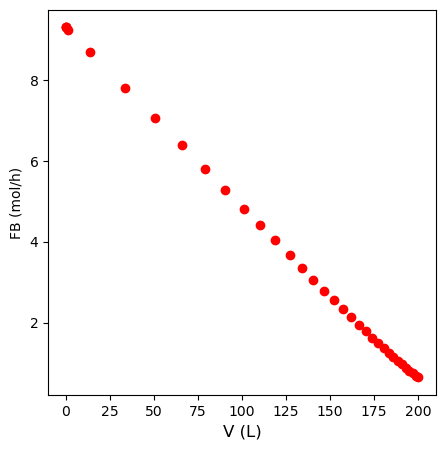

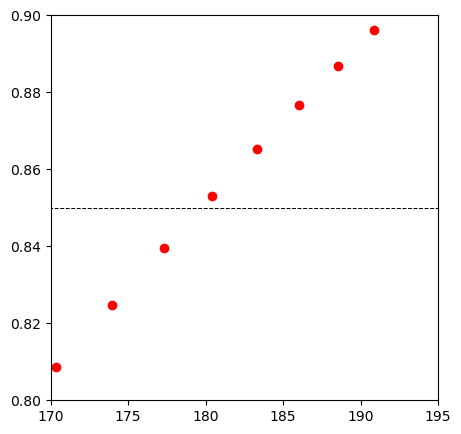

V = 179.72L


In [17]:
###############################################################################################
# Define the function that describes our system of ODEs to be solved using solve_ivp()        #
###############################################################################################

def P01(vol, var):
    FA = var[0] #notice that FA, FB, FC are elements [0, 1, 2] in the array called var
    FB = var[1]
    FC = var[2]
    # FA, FB, FC = var # this is a roughly equivalent way to unpack var
    FT = FA + FB + FC
    
    T  = 573 #K
    P  = 1.0 #atm
    R  = 0.08206 #L*atm/mol/K
    Q  = FT*R*T/P
    
    CA = FA/Q
    CB = FB/Q
    
    r  = k*CA*CB
    
    RA = -6*r
    RB = -19*r
    RC = r
    
    dFAdV = RA
    dFBdV = RB
    dFCdV = RC
    return [dFAdV, dFBdV, dFCdV] #notice that the order of derivatives here matches the order of the state variables. Python doesn't identify them by name, only by index order

##################################################################
# Set initial values, integration parameters                     #
##################################################################

FAf   = 3.7 #mol/h
FBf   = 9.3 #mol/h
FCf   = 0.0 #mol/h
vspan = (0, 200)
var0  = [FAf, FBf, FCf]

##################################################################
# Solve the problem using solve_ivp()                            #
##################################################################

ans09 = solve_ivp(P01, vspan, var0, atol = 1e-10, rtol = 1e-10)


##################################################################
# Bind elements from solution structure to variable names        # 
# Work up data to calculate conversions                          #
################################################################## 

V     = ans09.t
FB    = ans09.y[1,:]
XB    = (FBf - FB)/FBf


##################################################################
# Graph FB vs. Volume -- hard to tell where XB = 0.85 here?      #
##################################################################

plt.figure(figsize = (5,5))
plt.plot(V, FB, 'ro')
plt.xlabel('V (L)', fontsize = 12)
plt.ylabel('FB (mol/h)')
plt.show()

##################################################################
# Graph XB vs. Volume -- easier to see where XB = 0.85           #
##################################################################

plt.figure(figsize = (5,5))
plt.plot(V, XB, 'ro')
plt.hlines(0.85, 0, 200, color = 'black', linestyle = 'dashed', linewidth = 0.75)
plt.xlim(170, 195)
plt.ylim(0.8, 0.9)
plt.show()


##################################################################
# Use interpolation to find desired value of XB = 0.85           #
##################################################################

itp1  = interp1d(XB, V, kind = 'cubic')
Vsol  = itp1(0.85)
print(f'V = {Vsol:5.2f}L')

## Example Problem 02

Consider the following liquid-phase, irreversible, homogeneous reaction that is occurring in an isothermal, well-mixed,  batch reactor: 

$$A + B \rightarrow C$$

This reaction is first order in $A$ and first order in $B$. You may assume that the liquid inside of the reactor has a constant density (it is mostly solvent). Additional data are given below:

\begin{align*}
    k &= 0.0975 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
    C_{A0} &= 0.62 \ \textrm{mol} \ \textrm{L}^{-1}\\
    C_{B0} &= 1.35 \ \textrm{mol} \ \textrm{L}^{-1}\\
    V_0 &= 17 \textrm{L}
\end{align*}

What fractional conversion of species $A$ is achieved after 16 hours? 	

**Answer**: $X_A = 0.797$

### Solution to Example Problem 02

This problem asks us to determine how long it takes to convert a certain quantity of reactant in a batch reactor. This prompts us to write a material balance on Species A in a well-mixed batch reactor:

$$\frac{dN_A}{dt} = R_AV$$

We define $R_j$ in terms of reaction rates, $r_i$ and stoichiometric coefficients, $\nu_{i,j}$ as usual:

$$R_A = \sum_{i = 1}^{N_R} \nu_{i,A} \, r_i$$

We again have a single reaction, so:

$$R_A = -r$$

The problem statement tells us that the reaction is first order in A and first order in B, so:

$$r = kC_AC_B$$

Then:

$$R_A = -kC_AC_B$$

We substitute this into the material balance to get:

$$\frac{dN_A}{dt} = -kC_AC_BV$$

We encounter the usual situation where we have a single ODE that is written in terms of 1 independent variable (time) and 3 dependent variables $(N_A, \ C_A, \ C_B)$.  We ***can*** use the approaches from [Notebook 16](https://jqbond.github.io/CEN587/Notebooks/587-N16.html), [Notebook 17](https://jqbond.github.io/CEN587/Notebooks/587-N17.html), and [Notebook 18](https://jqbond.github.io/CEN587/Notebooks/587-N18.html) to obtain a hand solution for this problem. That is, we can express $N_A$, $C_A$, and $C_B$ all as functions of fractional conversion of species $A$, $X_A$. But we will simply ***choose*** to solve it by writing balances on each species that we either (1) need to keep track of to facilitate a solution or (2) want to keep track of for our analysis. Here, we only need to keep track of $A$ and $B$ to solve the problem.  Volume is constant, so the concentrations of species only depend on the number of moles of $A$ and $B$ in the system at any point in time.

With this approach in mind, we write balances on $A$ and $B$:

\begin{align*}
    \frac{dN_A}{dt} = R_AV \\
    \frac{dN_B}{dt} = R_BV \\
\end{align*}

Now, we just make sure that we define everything on the right hand side of the differential equations in terms of $N_A$, $N_B$, and/or $t$.  If we can do that, we can solve the problem using `solve_ivp()`.

We define the production rates:

\begin{align}
    R_A = -r \\
    R_B = -r \\
\end{align}

The rate expression:

$$r = kC_AC_B$$

And the concentrations:

\begin{align}
    C_A = N_A/V \\
    C_B = N_B/V \\
\end{align}

In this case, volume is constant at 17L, so we have basically solved the problem. All we need to do is write up these equations as a function that we can integrate with `solve_ivp()`.

In [20]:
#######################################################################################################
# Define the system of ODEs to be solved using a function that complies with solve_ivp() requirements #
#######################################################################################################

def P02(t, var):
    k  = 0.0975 #L/mol/h
    V  = 17.0   #L
    
    NA = var[0]
    NB = var[1]
    
    CA = NA/V
    CB = NB/V
    
    r  = k*CA*CB
    
    RA = -r
    RB = -r
    
    dNAdt = RA*V
    dNBdt = RB*V
    return [dNAdt, dNBdt]

################################################################################
# Define parameters and constants                                              #
################################################################################

V0  = 17.0 #L
CA0 = 0.62 #mol/L
CB0 = 1.35 #mol/L
NA0 = CA0*V0 #mol
NB0 = CB0*V0 #mol

################################################################################
# Set integration parameters                                                   #
################################################################################

tspan = (0.0, 16.0)
var0  = [NA0, NB0]

################################################################################
# Solve the problem using solve_ivp()                                          #
################################################################################

ans07 = solve_ivp(P02, tspan, var0, atol = 1e-10, rtol = 1e-10)

################################################################################
# Extract quantities of interest, calculate fractional conversion              #
################################################################################

NA    = ans07.y[0,:]
XA    = (NA0 - NA)/NA0

################################################################################
# We are interested in conversion at 16 hours, which is the end of the span    #
################################################################################

print(f'At t = 16 hours, XA = {XA[-1]:5.3f}')

At t = 16 hours, XA = 0.797
